In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.compose import make_column_transformer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import mean_squared_error,r2_score, mean_absolute_error
from sklearn.preprocessing import LabelEncoder,OrdinalEncoder,MinMaxScaler, OneHotEncoder
from sklearn.feature_selection import mutual_info_regression
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics
from sklearn.feature_selection import SelectKBest, f_regression

#### Some visual settings

In [2]:
plt.rcParams["font.family"] = "Luminari"
sns.set_theme(style='whitegrid', palette='magma')
sns.set(style='ticks')

In [4]:
df= pd.read_csv('data.csv', sep=';')

#### Reengineered features

In [6]:
#Re engineered features

df['grade_avg_G12'] = (df['G1'] + df['G2'])/2
df['Pedu'] = (df['Medu'] + df['Fedu'])/2
# non study time
df['non_studytime'] = (10 - df[['studytime']])
# effort index based on these features combined
df['effort_index'] = df[['non_studytime','freetime','failures','absences','goout','Walc',]].sum(axis=1)


/var/folders/80/wdc67jbn5t595hmj0r1v6jhw0000gn/T/ipykernel_29585/4001630635.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['effort_index'], bins=100, rug=True, ax=axs[0]);


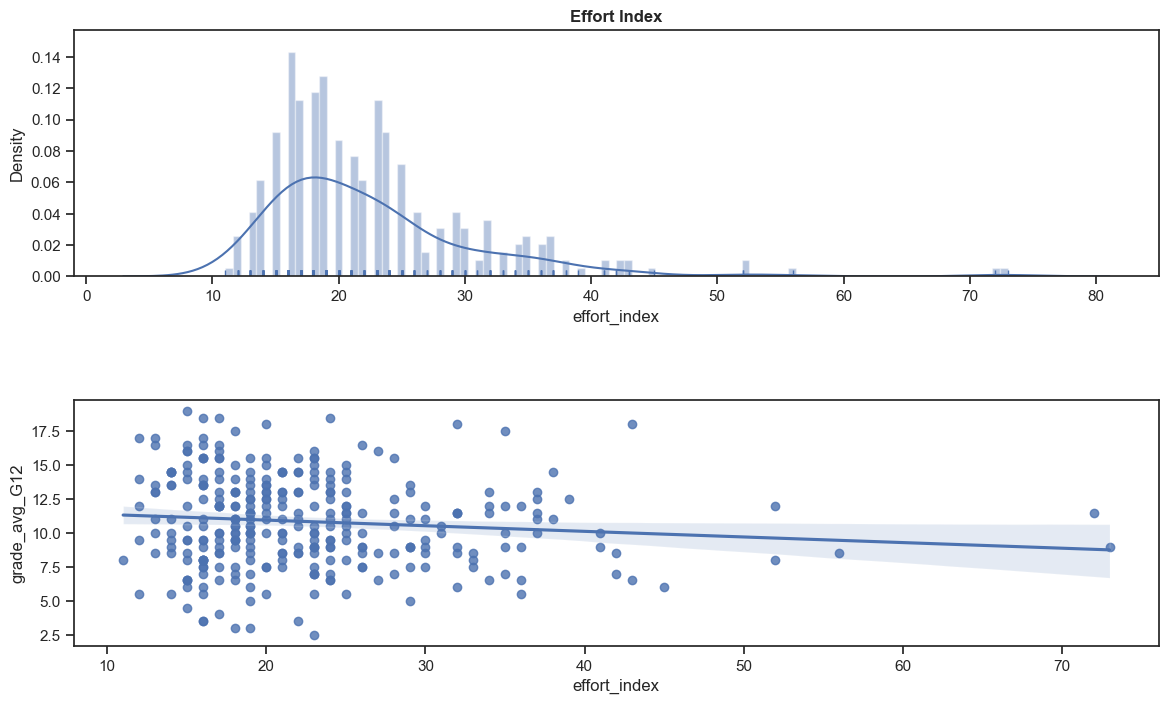

In [7]:

fig, axs = plt.subplots(nrows=2, figsize=(14, 8))
fig.subplots_adjust(wspace=0.3, hspace=0.5)
axs[0].set_title('Effort Index',  weight='bold')
sns.distplot(df['effort_index'], bins=100, rug=True, ax=axs[0]);
sns.regplot(x='effort_index', y='grade_avg_G12', data=df, ax=axs[1]);


In [8]:
print(df.head().T)
df.shape

                      0       1        2           3       4
school               GP      GP       GP          GP      GP
sex                   F       M        M           F       M
age                  16      18       17          15      16
address               U       U        R           U       U
famsize             LE3     LE3      LE3         LE3     GT3
Pstatus               T       T        A           T       T
Medu                  4       1        4           3       2
Fedu                  3       1        4           2       3
Mjob            teacher   other  teacher    services   other
Fjob           services   other    other       other   other
reason           course  course   course  reputation    home
guardian         mother  mother   mother      mother  father
traveltime            3       1        2           1       2
studytime             2       1        2           2       1
failures              0       3        0           0       0
schoolsup            no 

(316, 37)

#### Split data for the model

In [10]:
# (80%-20%) train-test split and setting random seed for consistency
train_set, test_set = train_test_split(df, test_size=0.2, random_state=40)

# get training data
y_train = train_set['G3']
X_train = train_set.drop('G3', axis=1)

# get test data
y_test = test_set['G3']
X_test = test_set.drop('G3', axis=1)


#### Feature categories

In [13]:
binary_features = ['school', 'sex', 'address', 'famsize', 'Pstatus', 'schoolsup', 'famsup',
                   'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']

# list of categorical features to be one-hot-encoded (label binarized)
catego_features = ['Mjob', 'Fjob', 'reason', 'guardian']

# list of numerical features
numerical_features = ['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel',
                      'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2', 'effort_index']


#### First set of models using encode data and SelectKBest 

In [14]:

models = [
    ('Linear Regression', LinearRegression()),
    ('Ridge Regression', Ridge(solver='sag', alpha=0.5, max_iter=10000, random_state=40)),
    ('Lasso Regression', Lasso(random_state=40,max_iter=10000)),
    ('KNeighbour Regression', KNeighborsRegressor(n_neighbors=3)),
    ('DecisionTree Regression', DecisionTreeRegressor(random_state=40)),
    ('RandomForest Regression', RandomForestRegressor(n_estimators=10, random_state=40))
]

# Set the range of k values for feature selection
k_values = range(3, 36)

results = []

# Loop over models
for model_name, model in models:
    model_results = []  
    for k in k_values:
        
        pipeline = Pipeline([
            ('preprocessor', ColumnTransformer([
                ('binary_pipeline', OrdinalEncoder(), binary_features),
                ('categorical_pipeline', OneHotEncoder(sparse_output=False), catego_features),
                ('numerical_pipeline', SimpleImputer(strategy='median'), numerical_features),
            ])),
            ('feature_selector', SelectKBest(score_func=f_regression, k=k)),
            ('model', model),
        ])

        # Fit the pipeline on your training data
        pipeline.fit(X_train, y_train)

        # Predict using the pipeline on your test data
        pred = pipeline.predict(X_test)

        scores = cross_val_score(pipeline, X_train, y_train, scoring="neg_mean_squared_error", cv=10)

        mse = mean_squared_error(y_test, pred)

        rmse_scores = np.sqrt(metrics.mean_squared_error(y_test, pred))

        mae = mean_absolute_error(y_test, pred)

        r2 = r2_score(y_test, pred)
        
        relative_error = mae / y_test.mean()

        # Append the results to the list for the current model
        model_results.append({
            'Model': f'{model_name} (k={k})',
            'MAE': mae,
            'MSE': mse,
            'RMSE': rmse_scores,
            'Cross Validation': scores.mean(),
            'R2': r2,
            'Relative Error': relative_error
            })

    # Sort the results for the current model by R2 score and select the top three
    model_results = sorted(model_results, key=lambda x: x['R2'], reverse=True)[:3]

    # Append the top three results for the current model to the overall results list
    results.extend(model_results)


results_df = pd.DataFrame(results)
best_model_result = max(results, key=lambda x: x['R2'])
print('Best Model', best_model_result)
results_df


Best Model {'Model': 'KNeighbour Regression (k=28)', 'MAE': 1.046875, 'MSE': 2.394097222222222, 'RMSE': 1.5472870523022617, 'Cross Validation': -5.800239316239316, 'R2': 0.8611469036684618, 'Relative Error': 0.10229007633587786}


,Model,MAE,MSE,RMSE,Cross Validation,R2,Relative Error
0,Linear Regression (k=25),1.215428,3.224133,1.795587,-5.013093,0.813006,0.118759
1,Linear Regression (k=24),1.190540,3.232203,1.797833,-4.970016,0.812538,0.116328
2,Linear Regression (k=26),1.187025,3.252390,1.803438,-5.120451,0.811368,0.115984
3,Ridge Regression (k=25),1.207288,3.202707,1.789611,-4.983514,0.814249,0.117964
4,Ridge Regression (k=24),1.182317,3.210704,1.791844,-4.941860,0.813785,0.115524
5,Ridge Regression (k=26),1.180140,3.235244,1.798678,-5.084883,0.812362,0.115311
6,Lasso Regression (k=4),1.060212,3.384877,1.839804,-4.352850,0.803684,0.103593
7,Lasso Regression (k=5),1.060212,3.384877,1.839804,-4.352850,0.803684,0.103593
8,Lasso Regression (k=6),1.060212,3.384877,1.839804,-4.352850,0.803684,0.103593
9,KNeighbour Regression (k=28),1.046875,2.394097,1.547287,-5.800239,0.861147,0.102290


### Model comparision top 3 in each models

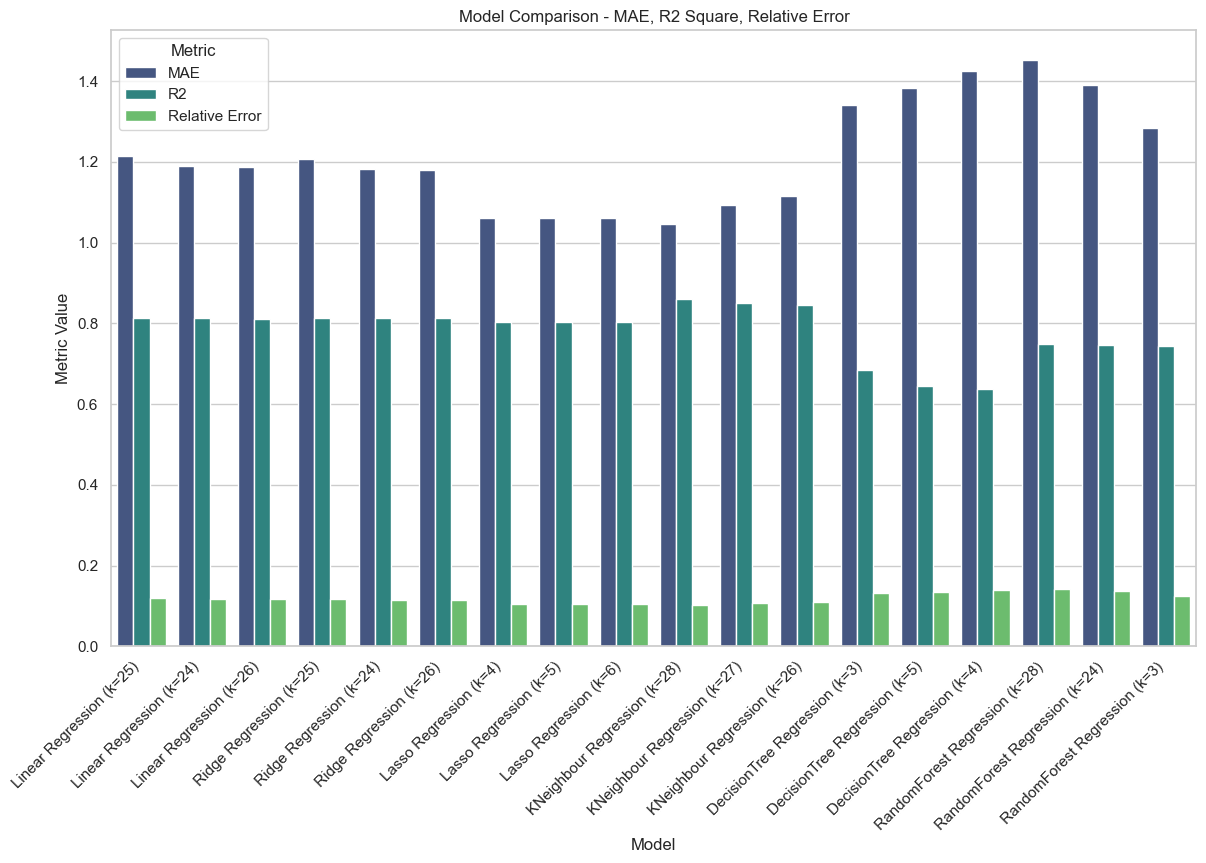

In [18]:
df_values_subset = results_df[['Model', 'MAE', 'R2', 'Relative Error']]

model_results = pd.melt(df_values_subset, id_vars=['Model'], var_name='Metric', value_name='Value')

sns.set_theme(style="whitegrid") 


plt.figure(figsize=(14, 8)) 
sns.barplot(x='Model', y='Value', hue='Metric', data=model_results, palette='viridis')
plt.title('Model Comparison - MAE, R2 Square, Relative Error')
plt.ylabel('Metric Value')
plt.xticks(rotation=45, ha='right') 
plt.legend(title='Metric')
plt.show()

#### Best model from above with sample test prediction

In [19]:
#Best model
pipeline = Pipeline([
            ('preprocessor', ColumnTransformer([
                ('binary_pipeline', OrdinalEncoder(), binary_features),
                ('categorical_pipeline', OneHotEncoder(), catego_features),
                ('numerical_pipeline', SimpleImputer(strategy='median'), numerical_features),
            ])),
            ('feature_selector', SelectKBest(score_func=f_regression, k=28)),
            ('model', KNeighborsRegressor(n_neighbors=3)),
        ])

      
pipeline.fit(X_train, y_train)

pred = pipeline.predict(X_test)

for idx in range(21, 31):
    print(f'Test prediction: {pred[idx]:.2f} - Actual grade: {y_test.iat[idx]}')


Test prediction: 6.00 - Actual grade: 5
Test prediction: 10.00 - Actual grade: 10
Test prediction: 10.00 - Actual grade: 10
Test prediction: 11.00 - Actual grade: 11
Test prediction: 13.33 - Actual grade: 14
Test prediction: 10.00 - Actual grade: 10
Test prediction: 13.00 - Actual grade: 13
Test prediction: 4.33 - Actual grade: 5
Test prediction: 10.00 - Actual grade: 10
Test prediction: 0.00 - Actual grade: 0


#### Visual of sample test prediction

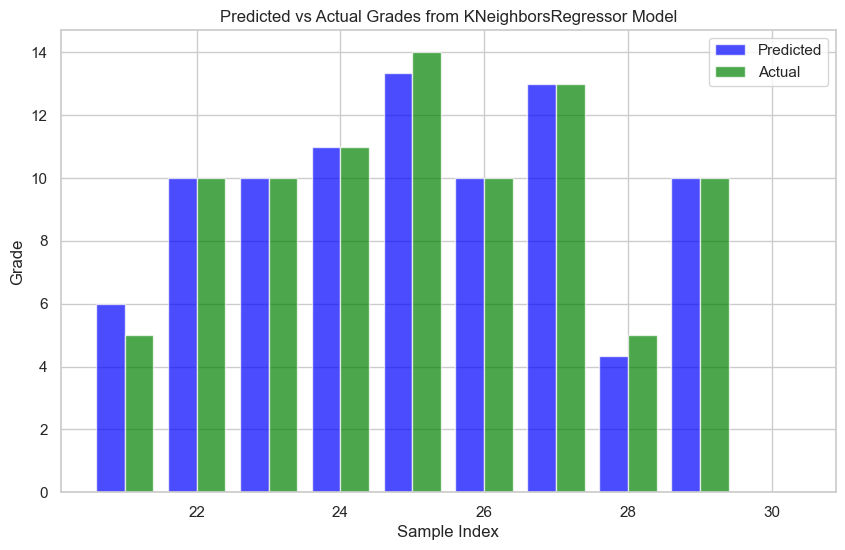

In [20]:
indices = range(21, 31)
plt.figure(figsize=(10, 6))
plt.bar(np.array(indices) - 0.2, pred[indices], label='Predicted', alpha=0.7, width=0.4, color='blue')
plt.bar(np.array(indices) + 0.2, y_test.iloc[indices], label='Actual', alpha=0.7, width=0.4, color='green')
plt.xlabel('Sample Index')
plt.ylabel('Grade')
plt.title('Predicted vs Actual Grades from KNeighborsRegressor Model')
plt.legend()
plt.show()

##### Part-2 Random Forest Regression Model with RandomizedSearchCV- hyper parameter tuning

In [21]:
pipeline = ColumnTransformer([
    ('binary_pipeline', OrdinalEncoder(), binary_features),
    ('catego_pipeline', OneHotEncoder(sparse_output=False), catego_features),
    ('numerical_pipeline', SimpleImputer(strategy='median'), numerical_features),
])

X_train = pipeline.fit_transform(X_train)
X_test = pipeline.transform(X_test)

In [22]:
# hyper parameter tuning
param_distributions = {
        'n_estimators': randint(low=1, high=100),
        'max_features': randint(low=1, high=36),
    }

rnd_search = RandomizedSearchCV(RandomForestRegressor(random_state=40),
                                param_distributions=param_distributions,
                                n_iter=100,
                                cv=10,
                                scoring='neg_mean_squared_error',
                                random_state=40)

rnd_search.fit(X_train, y_train)

RandomizedSearchCV(cv=10, estimator=RandomForestRegressor(random_state=40),
                   n_iter=100,
                   param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x14457daf0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x147c857f0>},
                   random_state=40, scoring='neg_mean_squared_error')

In [23]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(params,np.sqrt(-mean_score))

{'max_features': 7, 'n_estimators': 92} 2.396861458742781
{'max_features': 8, 'n_estimators': 38} 2.2332515597887657
{'max_features': 2, 'n_estimators': 13} 3.31833378350808
{'max_features': 8, 'n_estimators': 20} 2.311021419199744
{'max_features': 32, 'n_estimators': 75} 1.7146159421455958
{'max_features': 20, 'n_estimators': 60} 1.807904415633851
{'max_features': 28, 'n_estimators': 74} 1.7482544855189102
{'max_features': 33, 'n_estimators': 50} 1.7742656292328167
{'max_features': 10, 'n_estimators': 9} 2.324146342277716
{'max_features': 31, 'n_estimators': 80} 1.733100545265623
{'max_features': 15, 'n_estimators': 93} 1.8744715013032447
{'max_features': 11, 'n_estimators': 23} 2.0720384451808322
{'max_features': 4, 'n_estimators': 92} 2.726623174387647
{'max_features': 8, 'n_estimators': 56} 2.231905866540021
{'max_features': 20, 'n_estimators': 29} 1.848711150690271
{'max_features': 14, 'n_estimators': 38} 1.86468018050835
{'max_features': 19, 'n_estimators': 51} 1.90035263449994
{

In [24]:
# get the model with the best set of hyperparameters for regression forest
best_model = rnd_search.best_estimator_
best_model

RandomForestRegressor(max_features=35, n_estimators=71, random_state=40)

In [26]:
best_model.fit(X_train, y_train)
rfbest_trainpred = best_model.predict(X_train)


#### Prediction from training data 

In [27]:
# training predictions values
for x in range(31, 41):
       print(f'Training prediction: {rfbest_trainpred[x]:.2f} -vs- Actual grade: {y_train.iat[x]}')

Training prediction: 9.85 -vs- Actual grade: 10
Training prediction: 10.03 -vs- Actual grade: 10
Training prediction: 11.31 -vs- Actual grade: 12
Training prediction: 13.61 -vs- Actual grade: 13
Training prediction: 9.08 -vs- Actual grade: 9
Training prediction: 13.61 -vs- Actual grade: 14
Training prediction: 13.18 -vs- Actual grade: 13
Training prediction: 18.07 -vs- Actual grade: 18
Training prediction: 9.54 -vs- Actual grade: 10
Training prediction: 7.04 -vs- Actual grade: 8


#### Test data metrics

In [28]:
rfbest_testpred = best_model.predict(X_test) 

scores = cross_val_score(best_model, X_train, y_train, scoring="neg_mean_squared_error", cv=10)

mse = mean_squared_error(y_test, rfbest_testpred)

rmse_scores = np.sqrt(metrics.mean_squared_error(y_test, rfbest_testpred))

mae = mean_absolute_error(y_test, rfbest_testpred)

r2 = r2_score(y_test, rfbest_testpred)

relative_error = mae / y_test.mean()
print(scores.mean(),mse,rmse_scores,mae,r2,relative_error)

-2.70425693925198 3.0137373536996623 1.736011910586924 1.025088028169014 0.8252089517472521 0.10016127298139985


#### Sample from test data predictions

In [29]:
# some examples from test set
for idx in range(21, 31):
    print(f'Test prediction: {rfbest_testpred[idx]:.2f} - Actual grade: {y_test.iat[idx]}')
 

Test prediction: 5.31 - Actual grade: 5
Test prediction: 10.04 - Actual grade: 10
Test prediction: 9.38 - Actual grade: 10
Test prediction: 11.04 - Actual grade: 11
Test prediction: 14.01 - Actual grade: 14
Test prediction: 9.01 - Actual grade: 10
Test prediction: 13.06 - Actual grade: 13
Test prediction: 5.77 - Actual grade: 5
Test prediction: 8.58 - Actual grade: 10
Test prediction: 0.75 - Actual grade: 0


#### Test data predicted -visual

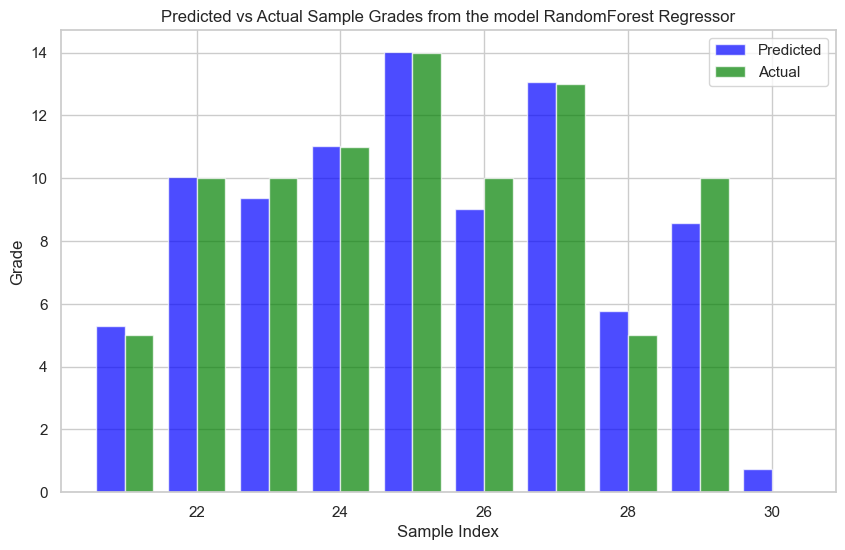

In [30]:

indices = range(21, 31)
plt.figure(figsize=(10, 6))
plt.bar(np.array(indices) - 0.2, rfbest_testpred[indices], label='Predicted', alpha=0.7, width=0.4, color='blue')
plt.bar(np.array(indices) + 0.2, y_test.iloc[indices], label='Actual', alpha=0.7, width=0.4, color='green')
plt.xlabel('Sample Index')
plt.ylabel('Grade')
plt.title('Predicted vs Actual Sample Grades from the model RandomForest Regressor')
plt.legend()
plt.show()